In [1]:
import numpy as np
import torch
from scipy import signal as sgl
from matplotlib import pyplot as plt
import matplotlib as mpl
from parameters_info import sample_uniform_around, parameters_alpha_peak,parameters_range_bounds
from simulators import WC_stochastic_heun_PSD
from torch import nn
from torch import optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mpl.rcParams['font.size'] = 20
# precompile simulator 
_, _, _ = WC_stochastic_heun_PSD(np.array([parameters_alpha_peak]),length = 6, dt=1,noise_seed=12)

In [2]:
# Total number of samples split into chunks
chunk_size, num_chunks = 500, 4
parameters_samples = torch.as_tensor(sample_uniform_around(chunk_size*num_chunks, width = parameters_range_bounds*0.05)) 
dt = 1
length = 302
cutoff = 200 # 100Hz (resolution of 0.5Hz)
simulated_samples = []
for i in range(num_chunks):
  parameters = parameters_samples[chunk_size*i:chunk_size*(i+1),:]
  psd_E, freq = WC_stochastic_heun_PSD(parameters,length = length, dt=dt, noise_seed=np.random.randint(0,2**16), PSD_cutoff=cutoff, get_psd_I=False, remove_bad=True)
  simulated_samples.append(psd_E)
simulated_samples = torch.cat(simulated_samples,dim = 0)
print(simulated_samples.shape)

torch.Size([1999, 200])


In [89]:
class AE(nn.Module):
    def __init__(self, latent_dim = 4, input_size = 200, num_units = 128):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=input_size, out_features=num_units
        )
        self.encoder_hidden_layer2 = nn.Linear(
            in_features=num_units, out_features=num_units//4
        )
        self.encoder_output_layer = nn.Linear(
            in_features=num_units//4, out_features=latent_dim
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=latent_dim, out_features=num_units//4
        )
        self.decoder_hidden_layer2 = nn.Linear(
            in_features=num_units//4, out_features=num_units
        )
        self.decoder_output_layer = nn.Linear(
            in_features=num_units, out_features = input_size
        )
        self.activation_fn = torch.nn.functional.silu 

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = self.activation_fn(activation)
        activation = self.encoder_hidden_layer2(activation)
        activation = self.activation_fn(activation)
        code = self.encoder_output_layer(activation)
        code = self.activation_fn(code)
        activation = self.decoder_hidden_layer(code)
        activation = self.activation_fn(activation)
        activation = self.decoder_hidden_layer2(activation)
        activation = self.activation_fn(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = self.activation_fn(activation)
        return reconstructed
    
    def get_latent(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = self.activation_fn(activation)
        code = self.encoder_output_layer(activation)
        code = self.activation_fn(code)
        return code
model = AE(input_size=cutoff,latent_dim=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.MSELoss()

In [37]:
train_dataset = simulated_samples[:int(0.8*simulated_samples.shape[0]),:].float() * 1000
test_dataset = simulated_samples[int(0.8*simulated_samples.shape[0]):,:].float() * 1000
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=int(0.2*simulated_samples.shape[0]), shuffle=True
)

In [90]:
epochs = 400
for epoch in range(epochs):
    loss = 0
    for batch_features in train_loader:
        batch_features = batch_features.view(-1, 200).to(device)
        optimizer.zero_grad()
        outputs = model(batch_features)
        train_loss = criterion(outputs, batch_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    loss = loss / len(train_loader)
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss), end="\r", flush=True)

tensor(0.0162, grad_fn=<MeanBackward0>)


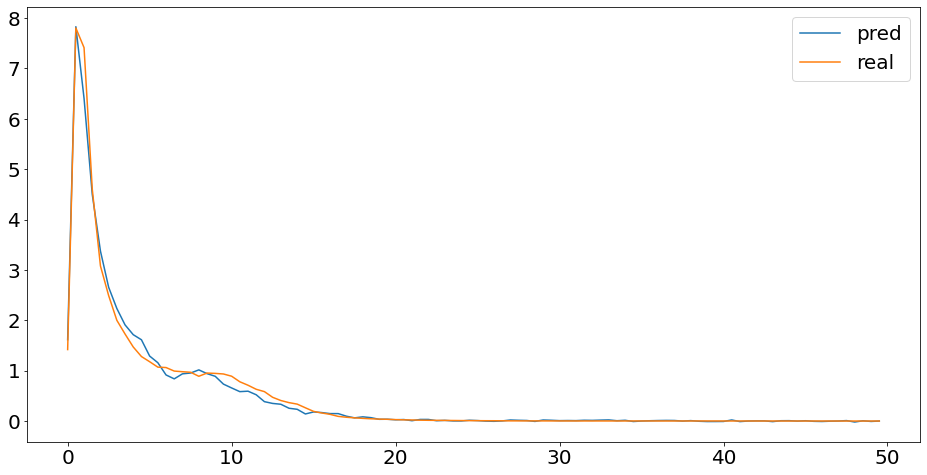

In [92]:
index = 25
pred = model(test_dataset.to(device)).to("cpu")
print(torch.mean((test_dataset-pred)**2))
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,1,1)
plt.plot([0.5*i for i in range(100)],pred[index,:100].detach().numpy(), label = "pred")
plt.plot([0.5*i for i in range(100)],test_dataset[index,:100].detach().numpy(), label = "real")
plt.legend()
plt.show()